In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC as KerasAUC

import sklearn
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import class_weight

import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --- Task 2.1: Load Preprocessed Data ---

print("Loading preprocessed data from 'artifacts/preprocessed_data.joblib'...")
try:
    data = joblib.load('./artifacts/preprocessed_data.joblib')
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']
    print("Data loaded successfully.")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
except FileNotFoundError:
    print("Error: 'artifacts/preprocessed_data.joblib' not found.")
    print("Please run the 01-eda-preprocessing.ipynb notebook to generate the data.")

Loading preprocessed data from 'artifacts/preprocessed_data.joblib'...
Data loaded successfully.
X_train shape: (71541, 37)
y_train shape: (71541,)


In [3]:
# --- Task 2.2: Handle Class Imbalance ---

# Calculate class weights
# This tells the model to "pay more attention" to the minority class
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = dict(enumerate(weights))
print(f"Class weights: {class_weights_dict}")
print("Class 0 (Fully Paid) will be weighted by: {:.2f}".format(weights[0]))
print("Class 1 (Defaulted) will be weighted by: {:.2f}".format(weights[1]))

Class weights: {0: np.float64(0.6229840816468704), 1: np.float64(2.532783402959711)}
Class 0 (Fully Paid) will be weighted by: 0.62
Class 1 (Defaulted) will be weighted by: 2.53


In [4]:
# --- Task 2.3: Build and Train DL Model ---
# We will build a simple Multi-Layer Perceptron (MLP) [cite: 32]

# Get the number of input features from the shape of X_train
input_dim = X_train.shape[1]
print(f"Model input dimension: {input_dim}")

def build_model(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(0.3)) # Dropout for regularization
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid')) # Sigmoid for binary classification
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[KerasAUC(name='auc')] # Track AUC during training
    )
    return model

model = build_model(input_dim)
model.summary()

Model input dimension: 37


c:\Users\Ankit Aggarwal\Desktop\Shodh.ai Task\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,545 (17.75 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train the model
print("Starting model training...")

EPOCHS = 20 # Keep this low for a 1-day project
BATCH_SIZE = 256

history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2, # Use part of training data for validation
    class_weight=class_weights_dict, # Apply the class weights!
    verbose=1
)

print("Model training complete.")

Starting model training...
Epoch 1/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.6615 - loss: 0.6553 - val_auc: 0.6947 - val_loss: 0.6343
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6939 - loss: 0.6360 - val_auc: 0.6980 - val_loss: 0.6196
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.6999 - loss: 0.6316 - val_auc: 0.6989 - val_loss: 0.6295
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7023 - loss: 0.6305 - val_auc: 0.6980 - val_loss: 0.6356
Epoch 5/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7018 - loss: 0.6303 - val_auc: 0.6986 - val_loss: 0.6249
Epoch 6/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7044 - loss: 0.6291 - val_auc: 0.6983 - val_loss: 0.6275
Epoch 7/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - auc: 0.7052 - loss: 0.6281 - val_auc: 0.6989 - val_loss: 0.6270
Epoch 8/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.7049 - loss: 0.6274 - val_auc: 0.6990 - val_loss: 0.6300
Epoch 9/20
224/224 ━━━━━━━━━━

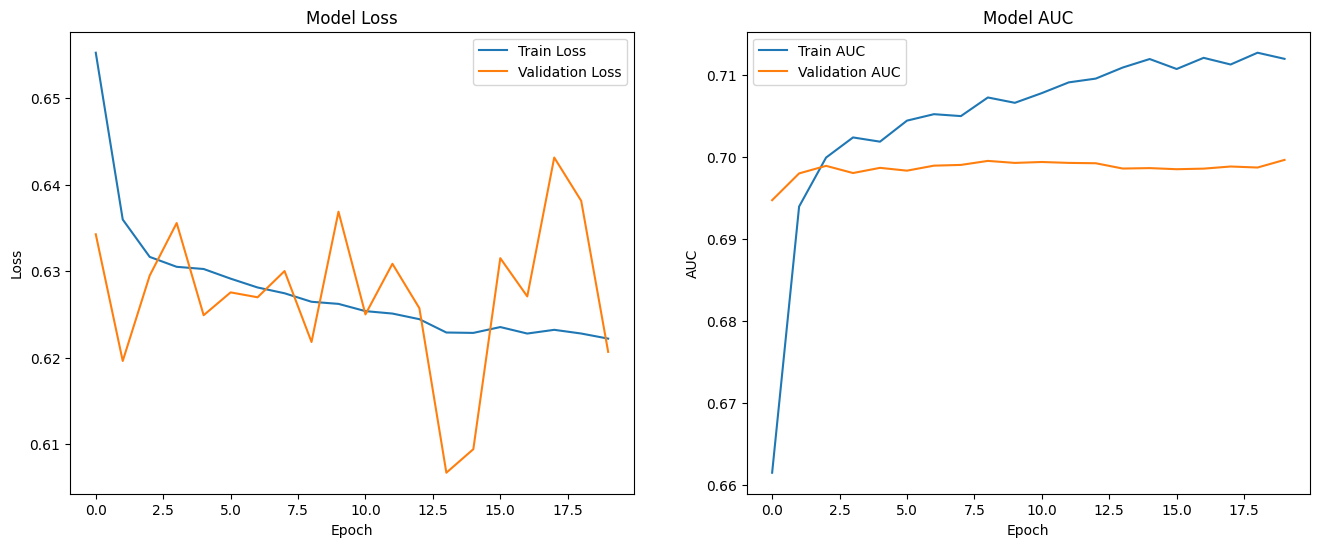

In [6]:
# Plot training history
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot loss
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot AUC
    ax2.plot(history.history['auc'], label='Train AUC')
    ax2.plot(history.history['val_auc'], label='Validation AUC')
    ax2.set_title('Model AUC')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('AUC')
    ax2.legend()
    
    plt.show()

plot_history(history)

Evaluating model on the held-out test set...
559/559 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step

--- Model 1 (Deep Learning) Results ---
Test Loss:     0.6176
Test AUC (Sklearn): 0.7086
Test F1-Score: 0.4218
---------------------------------------

Classification Report (Test Set):
                precision    recall  f1-score   support

Fully Paid (0)       0.89      0.62      0.73     14355
 Defaulted (1)       0.31      0.68      0.42      3531

      accuracy                           0.63     17886
     macro avg       0.60      0.65      0.58     17886
  weighted avg       0.77      0.63      0.67     17886



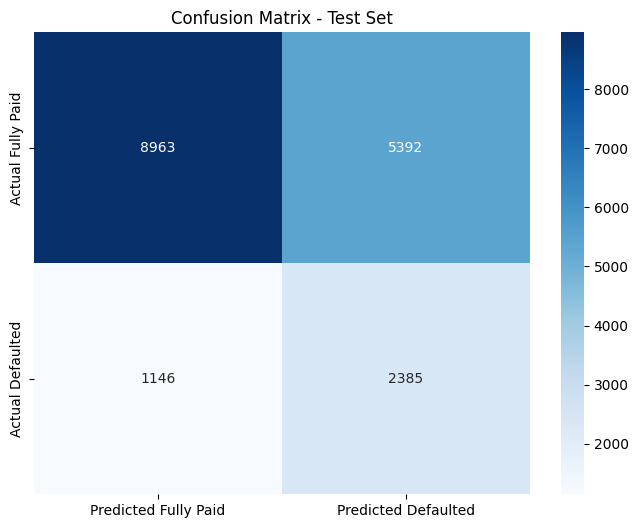

In [7]:
# --- Task 2.4: Evaluate Model Performance ---
print("Evaluating model on the held-out test set...")

# 1. Get model loss and AUC on the test set
loss, auc = model.evaluate(X_test, y_test, verbose=0)

# 2. Get probability predictions
y_pred_prob = model.predict(X_test).flatten()

# 3. Get binary predictions (using 0.5 as the threshold)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# 4. Calculate F1-Score (for the binary predictions)
f1 = f1_score(y_test, y_pred_binary)

# 5. Calculate AUC (for the probabilities)
# We already got 'auc' from model.evaluate(), but it's good to double-check
auc_sklearn = roc_auc_score(y_test, y_pred_prob)


print("\n--- Model 1 (Deep Learning) Results ---")
print(f"Test Loss:     {loss:.4f}")
print(f"Test AUC (Sklearn): {auc_sklearn:.4f}") # 
print(f"Test F1-Score: {f1:.4f}") # 
print("---------------------------------------")

# Show a detailed classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_binary, target_names=['Fully Paid (0)', 'Defaulted (1)']))

# Show a confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Fully Paid', 'Predicted Defaulted'],
            yticklabels=['Actual Fully Paid', 'Actual Defaulted'])
plt.title('Confusion Matrix - Test Set')
plt.show()


In [8]:
print("Saving the trained DL model...")
model.save('artifacts/dl_model.keras')
print("Model saved to 'artifacts/dl_model.keras'")

Saving the trained DL model...
Model saved to 'artifacts/dl_model.keras'
